# Final Version

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Dropout, GlobalAveragePooling2D, Input, Concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, InceptionV3
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.utils import plot_model
import cv2
import tensorflow as tf

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
img_width, img_height = 224, 224
batch_size = 32
epochs = 30

dataset_dir = "/kaggle/input/brain-tumor-mri-dataset/"
train_dir = os.path.join(dataset_dir, "Training")
test_dir  = os.path.join(dataset_dir, "Testing")
output_dir = "./results/"
os.makedirs(output_dir, exist_ok=True)

# ---------------- Data Generator (no validation) ----------------

def create_train_generator(preprocess_func=None):
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True
    )
    if preprocess_func:
        datagen.preprocessing_function = preprocess_func
    return datagen.flow_from_directory(
        directory=train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )


def create_test_generator(preprocess_func=None):
    datagen = ImageDataGenerator()
    if preprocess_func:
        datagen.preprocessing_function = preprocess_func
    return datagen.flow_from_directory(
        directory=test_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

# ---------------- Ensemble Architecture (Xception + InceptionV3) ----------------

def create_updated_ensemble_model(num_classes):
    input_tensor = Input(shape=(img_width, img_height, 3))

    # Xception branch
    xcep = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
    for layer in xcep.layers[-20:]:
        layer.trainable = True
    x1 = GlobalAveragePooling2D()(xcep.output)
    x1 = Dense(512, activation='relu')(x1)

    # InceptionV3 branch
    incep = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
    for layer in incep.layers[-20:]:
        layer.trainable = True
    x2 = GlobalAveragePooling2D()(incep.output)
    x2 = Dense(512, activation='relu')(x2)

    # Fuse features
    merged = Concatenate()([x1, x2])
    x = Dense(256, activation='relu')(merged)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ---------------- Grad-CAM Utility ----------------

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# ---------------- Training and Evaluation ----------------

if __name__ == "__main__":
    # Prepare data generators
    train_gen = create_train_generator(preprocess_func=xception_preprocess)
    test_gen  = create_test_generator(preprocess_func=xception_preprocess)

    num_classes = train_gen.num_classes
    class_names = list(train_gen.class_indices.keys())

    # Build model
    model = create_updated_ensemble_model(num_classes)

    # Visualize and save architecture (collapse nested models)
    try:
        plot_model(
            model,
            to_file=os.path.join(output_dir, 'model_architecture.png'),
            show_shapes=True,
            show_layer_names=True,
            expand_nested=True
        )
    except Exception as e:
        print("Graphviz plot failed:", e)
        model.summary()

    # Callbacks (monitor training loss since no validation)
    early_stopping = EarlyStopping(
        monitor='loss', patience=5, restore_best_weights=True, verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='loss', factor=0.2, patience=3,
        min_lr=1e-6, verbose=1
    )

    # Train
    history = model.fit(
        train_gen,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate
    test_gen.reset()
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.classes[:len(y_pred)]

    from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred, target_names=list(train_gen.class_indices.keys())))

    # Grad-CAM on a sample image
    img_path = test_gen.filepaths[0]
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_width, img_height))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = xception_preprocess(img_array)

    last_conv = 'block14_sepconv2'
    heatmap = make_gradcam_heatmap(img_array, model, last_conv)

    # Resize and colorize heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img_width, img_height))
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose
    original = cv2.imread(img_path)
    original = cv2.resize(original, (img_width, img_height))
    superimposed = cv2.addWeighted(original, 0.6, heatmap_colored, 0.4, 0)
    cv2.imwrite(os.path.join(output_dir, 'gradcam.jpg'), superimposed)
    print('Grad-CAM image saved to results/gradcam.jpg')

2025-04-25 16:54:28.657218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745600068.863631      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745600068.924177      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


I0000 00:00:1745600084.127726      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Graphviz plot failed: Program terminated with status: -6. stderr follows: failed at node 7957[0]
dot: maze.c:311: chkSgraph: Assertion `np->cells[0]' failed.



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 111, 111, 32)   │             96 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 109, 109, 32)   │             96 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 109, 109, 64)   │            192 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 54, 54, 80)     │            240 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 52, 52, 192)    │            576 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 45,025,868 (171.76 MB)

 Trainable params: 44,936,908 (171.42 MB)

 Non-trainable params: 88,960 (347.50 KB)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745600180.040975     107 service.cc:148] XLA service 0x7b01ac0035c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745600180.041867     107 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745600188.498150     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1745600209.320570     107 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745600209.521255     107 gpu_timer.cc:

 74/179 ━━━━━━━━━━━━━━━━━━━━ 52s 502ms/step - accuracy: 0.6315 - loss: 0.8604

E0000 00:00:1745600297.047593     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745600297.242000     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745600298.029904     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745600298.215708     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745600299.794665     105 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

179/179 ━━━━━━━━━━━━━━━━━━━━ 289s 794ms/step - accuracy: 0.7429 - loss: 0.6313 - learning_rate: 1.0000e-04
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 72s 383ms/step - accuracy: 0.9533 - loss: 0.1420 - learning_rate: 1.0000e-04
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 383ms/step - accuracy: 0.9692 - loss: 0.0942 - learning_rate: 1.0000e-04
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 72s 384ms/step - accuracy: 0.9721 - loss: 0.0846 - learning_rate: 1.0000e-04
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 72s 384ms/step - accuracy: 0.9823 - loss: 0.0582 - learning_rate: 1.0000e-04
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 381ms/step - accuracy: 0.9816 - loss: 0.0538 - learning_rate: 1.0000e-04
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 382ms/step - accuracy: 0.9891 - loss: 0.0399 - learning_rate: 1.0000e-04
Epoch 8/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 383ms/step - accuracy: 0.9911 - loss: 0.0348 - learning_rate: 1.0000e-04
Epoch 9/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 382ms/step - accuracy: 0.9916 

# Test of almost 3000 images of different dataset

In [2]:
import os
import glob
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess

# ── CONFIG ─────────────────────────────────────────────────────────────────────
img_width, img_height = 224, 224
batch_size = 32
dataset_dir = "/kaggle/input/brain-tumor-classification-mri"
train_dir   = os.path.join(dataset_dir, "Training")
test_dir    = os.path.join(dataset_dir, "Testing")
# ────────────────────────────────────────────────────────────────────────────────

# 1) Collect file paths & labels
classes = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]
records = []
for split in ["Training", "Testing"]:
    base = os.path.join(dataset_dir, split)
    for cls in classes:
        pattern = os.path.join(base, cls, "*")
        for filepath in glob.glob(pattern):
            records.append({"filepath": filepath, "class": cls})

df = pd.DataFrame(records)

# 2) Build a single evaluation generator
eval_datagen = ImageDataGenerator(preprocessing_function=xception_preprocess)
eval_gen = eval_datagen.flow_from_dataframe(
    dataframe        = df,
    x_col            = "filepath",
    y_col            = "class",
    target_size      = (img_width, img_height),
    class_mode       = "categorical",
    batch_size       = batch_size,
    shuffle          = False
)


# 4) Evaluate on the combined set
loss, acc = model.evaluate(eval_gen, verbose=1)
print(f"Combined Test set → loss: {loss:.4f}, accuracy: {acc:.4f}")

Found 3264 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 29s 202ms/step - accuracy: 0.9960 - loss: 0.0437
Combined Test set → loss: 0.2653, accuracy: 0.9737


102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step


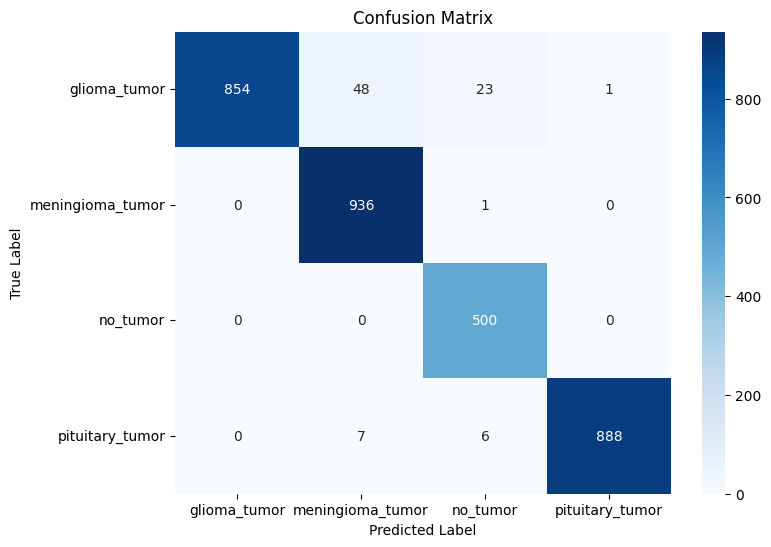

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.92      0.96       926
meningioma_tumor       0.94      1.00      0.97       937
        no_tumor       0.94      1.00      0.97       500
 pituitary_tumor       1.00      0.99      0.99       901

        accuracy                           0.97      3264
       macro avg       0.97      0.98      0.97      3264
    weighted avg       0.98      0.97      0.97      3264



In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1) Predict labels
y_pred = model.predict(eval_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# 2) True labels
y_true = eval_gen.classes

# 3) Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# 4) Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 5) Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=classes))



In [5]:
# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Number of images to process
n_images = 10

for idx in range(n_images):
    img_path = test_gen.filepaths[idx]

    # 1) Load & preprocess
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_width, img_height))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = xception_preprocess(img_array)

    # 2) Compute heatmap
    last_conv_layer = 'block14_sepconv2'
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer)

    # 3) Resize & colorize heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.resize(heatmap, (img_width, img_height))
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # 4) Superimpose on original
    original = cv2.imread(img_path)
    original = cv2.resize(original, (img_width, img_height))
    superimposed = cv2.addWeighted(original, 0.6, heatmap_colored, 0.4, 0)

    # 5) Save with a unique filename
    out_path = os.path.join(output_dir, f'gradcam_{idx}.jpg')
    cv2.imwrite(out_path, superimposed)
    print(f'Grad-CAM image saved to {out_path}')


Grad-CAM image saved to ./results/gradcam_0.jpg
Grad-CAM image saved to ./results/gradcam_1.jpg
Grad-CAM image saved to ./results/gradcam_2.jpg
Grad-CAM image saved to ./results/gradcam_3.jpg
Grad-CAM image saved to ./results/gradcam_4.jpg
Grad-CAM image saved to ./results/gradcam_5.jpg
Grad-CAM image saved to ./results/gradcam_6.jpg
Grad-CAM image saved to ./results/gradcam_7.jpg
Grad-CAM image saved to ./results/gradcam_8.jpg
Grad-CAM image saved to ./results/gradcam_9.jpg
